## VAE model on CelebA dataset

In [1]:
import os
import sys

from classes.VAE import VAE
from utils.callbacks import WandbImagesVAE, SaveGeneratorWeights, SaveVAEWeights
import tensorflow as tf
from tensorflow import keras
import numpy as np
import wandb
from wandb.keras import WandbCallback
from imutils import paths
from tensorflow.data import AUTOTUNE
import matplotlib.pyplot as plt


wandb.login()




wandb: Currently logged in as: matteoferrante (use `wandb login --relogin` to force relogin)


True

## Model definition and configurations

In [2]:
encoder_architecture=[(0,64),(0,128),(0,256),(0,384),(0,512)]
decoder_architecture=[(0,512),(0,384),(0,256),(0,128),(0,64)]

g=VAE((128,128,3),
      latent_dim=512,
      encoder_architecture=encoder_architecture,
      decoder_architecture=decoder_architecture,
      output_channels=3)


config={"dataset":"celebA", "type":"VAE","encoder_architecture":encoder_architecture,"decoder_architecture":decoder_architecture}
config.update(g.get_dict())



In [16]:
g.encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image_input (InputLayer)        [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv_res_block_5 (ConvResBlock) (None, 64, 64, 64)   1792        image_input[0][0]                
__________________________________________________________________________________________________
conv_res_block_6 (ConvResBlock) (None, 32, 32, 128)  73856       conv_res_block_5[0][0]           
__________________________________________________________________________________________________
conv_res_block_7 (ConvResBlock) (None, 16, 16, 256)  295168      conv_res_block_6[0][0]           
____________________________________________________________________________________________

In [17]:
g.decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
latent_input (InputLayer)    [(None, 512)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              525312    
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 64)          0         
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 4, 4, 64)          0         
_________________________________________________________________
conv_transpose_res_block_5 ( (None, 8, 8, 512)         295424    
_________________________________________________________________
conv_transpose_res_block_6 ( (None, 16, 16, 384)       1769856   
_________________________________________________________________
conv_transpose_res_block_7 ( (None, 32, 32, 256)       8849

In [28]:
images_dir=r"C:\Users\matte\Dataset\tor_vergata\Dataset\Img\img_align_celeba"
images_dir=r"/home/matteo/NeuroGEN/Dataset/Img/img_align_celeba"

#other important definitions

EPOCHS=50
BS=128
INIT_LR=1e-4

config["epochs"]=EPOCHS
config["BS"]=BS
config["init_lr"]=INIT_LR


In [19]:
#set the second GPU
os.environ["CUDA_VISIBLE_DEVICES"]="0"

print(os.environ.get("CUDA_VISIBLE_DEVICES"))

0


## Dataloaders

In [20]:
def load_images(imagePath):
    # read the image from disk, decode it, resize it, and scale the
    # pixels intensities to the range [0, 1]
    image = tf.io.read_file(imagePath)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (128, 128)) / 255.0

    #eventually load other information like attributes here
    
    # return the image and the extra info
    
    
    return image

In [21]:
wandb.init(project="TorVergataExperiment-Generative",config=config,name="VAE_CelebA")

wandb: wandb version 0.12.7 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [22]:
print("[INFO] loading image paths...")
imagePaths = list(paths.list_images(images_dir))


train_len=int(0.8*len(imagePaths))
val_len=int(0.1*len(imagePaths))
test_len=int(0.1*len(imagePaths))

train_imgs=imagePaths[:train_len]                                #      80% for training
val_imgs=imagePaths[train_len:train_len+val_len]                 #      10% for validation
test_imgs=imagePaths[train_len+val_len:]                         #      10% for testing

print(f"[TRAINING]\t {len(train_imgs)}\n[VALIDATION]\t {len(val_imgs)}\n[TEST]\t\t {len(test_imgs)}")

[INFO] loading image paths...
[TRAINING]	 113455
[VALIDATION]	 14181
[TEST]		 14183


In [23]:
#TRAINING 

train_dataset = tf.data.Dataset.from_tensor_slices(train_imgs)
train_dataset = (train_dataset
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

ts=len(train_imgs)//BS

##VALIDATION

val_dataset = tf.data.Dataset.from_tensor_slices(val_imgs)
val_dataset = (val_dataset
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .repeat()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

vs=len(val_imgs)//BS

## TEST

test_dataset = tf.data.Dataset.from_tensor_slices(test_imgs)
test_dataset = (test_dataset
    .shuffle(1024)
    .map(load_images, num_parallel_calls=AUTOTUNE)
    .cache()
    .batch(BS)
    .prefetch(AUTOTUNE)
)

[INFO] Visual check images in dataset


InvalidArgumentError: slice index 16 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

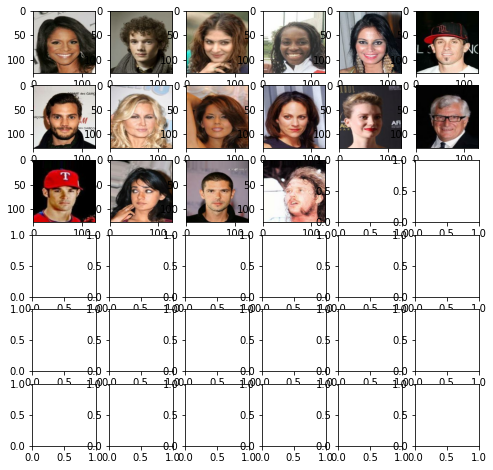

In [25]:
print(f"[INFO] Visual check images in dataset")
X=[]

for el in train_dataset:
    X.append(el)
    break
    
fig, axs=plt.subplots(6,6,figsize=(8,8))



for (i,ax) in enumerate(axs.ravel()):
    ax.imshow(X[0][i])

## Model Checkpoint

In [26]:
os.makedirs("models/vae",exist_ok=True)
model_check=SaveVAEWeights(filepath="models/vae")


callbacks=[
    WandbImagesVAE(val_dataset,target_shape=(128,128,3)),
    WandbCallback(),
    model_check,
]


## Model Training

In [29]:
g.compile(optimizer=keras.optimizers.Adam(learning_rate=INIT_LR))
g.fit(train_dataset,validation_data=test_dataset,steps_per_epoch=ts,validation_steps=vs,epochs=EPOCHS,callbacks=callbacks)


Epoch 1/50
 373/7090 [>.............................] - ETA: 6:29 - loss: nan - reconstruction_loss: nan - kl_loss: nan

KeyboardInterrupt: 